**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
%load_ext pycodestyle_magic

**IRIS**

In [2]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y): #Fit the model using X as training data and y as target values%%pycodestyle
            self.X_train = np.array(X).astype(float)
            self.y_train = np.array(y)            
            self.quantity_of_classes = len(np.unique(self.y_train))
            if (self.algorithm == 'kd_tree') :
                self.tree = KDTree(self.X_train)         
  
    def y_near_neighbors(self,X) :
        if (self.algorithm == 'brute') :         
            #dist=[[ np.linalg.norm(q-X[i]) for q in np.copy(self.X_train) ] for i in range(len(X))]
            #from scipy 
            #dist = scipy.spatial.distance.cdist(X, X_train,'minkowski', p=2)
            
            X = X.astype(float)
            X_train_squared = np.sum(self.X_train**2, axis=1).reshape(1, -1)
            X_test_squared = np.sum(X**2, axis=1).reshape(-1, 1)
            dist = np.sqrt( 
                            X_test_squared-2*np.matmul(X, self.X_train.T)+X_train_squared
                            )
            
            idx=np.argpartition(
                                dist, self.n_neighbors
                                )[:, :self.n_neighbors]
            
        if (self.algorithm == 'kd_tree') :   
            dist,idx = self.tree.query(X, k=self.n_neighbors)
        
        return self.y_train[idx].astype('int64')
    
    def predict(self, X): #Predict the class labels for the provided data
        y_of_near_neighbors = self.y_near_neighbors(X)
        return np.apply_along_axis(
                                    lambda x: np.bincount(x).argmax(), 1, y_of_near_neighbors
                                    )
        
    def count_y(self, x) :
        from collections import Counter
        res = []
        r = Counter(x)
        for i in range(self.quantity_of_classes) :
            res.append(r[i])
        res = np.array(res)
        return res
        #если использование Counter было запрещено то вариант ниже
        #return ( np.unique(np.concatenate((np.arange(self.quantity_of_classes), x)), return_counts=True )[1] - 1) 
        
    def predict_proba(self, X): #Return probability estimates for the test data X.
        return np.apply_along_axis(
                                    lambda x: self.count_y(x)/self.n_neighbors, 1, self.y_near_neighbors(X)
                                    )        
    
    def score(self, X, y): #Returns the mean accuracy on the given test data and labels.    
        sum = 0
        for i in (y == self.predict(X) ) :
            sum+=i
        return sum/len(y)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8.93 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 778 µs


In [8]:
%time clf.predict(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 7.44 ms


array([0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 383 ms


array([0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.75 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.47 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ]])

In [12]:
clf.score(X_test, y_test)

0.9333333333333333

In [13]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 3

/home/daliya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


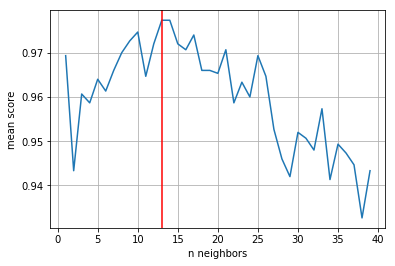

In [14]:
iteration = 100
result=[]
for i in range(1,40):
    res = []
    for j in range(iteration):
        X_train, X_test, y_train, y_test = train_test_split(iris.data, 
                                                            iris.target, 
                                                            test_size=0.1, 
                                                            stratify=iris.target
                                                            )
        my_clf = MyKNeighborsClassifier(n_neighbors=i)
        my_clf.fit(X_train, y_train)
        
        res.append(my_clf.score(X_test, y_test))
    result.append(np.mean(res))
result = np.array(result)

best_n = result.argmax()+1

plt.plot(range(1,40), result)
plt.xlabel("n neighbors")
plt.ylabel("mean score")
plt.axvline(best_n, color='red')
plt.grid()
plt.show()

**MNIST**

In [15]:
mnist = fetch_mldata('MNIST original')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [17]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [18]:
%time clf.fit(X_train, y_train)

CPU times: user 3min 8s, sys: 980 ms, total: 3min 9s
Wall time: 3min 8s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [19]:
%time my_clf.fit(X_train, y_train)

CPU times: user 188 ms, sys: 452 ms, total: 640 ms
Wall time: 766 ms


In [20]:
%time clf.predict(X_test)

CPU times: user 3min 55s, sys: 60 ms, total: 3min 55s
Wall time: 3min 55s


array([1., 4., 5., 9., 8., 2., 4., 0., 7., 0., 5., 4., 2., 5., 2., 0., 8.,
       4., 7., 6., 4., 1., 1., 1., 7., 3., 8., 3., 8., 1., 7., 4., 5., 7.,
       5., 1., 9., 6., 6., 9., 3., 0., 3., 7., 2., 8., 3., 4., 6., 6., 3.,
       8., 7., 7., 4., 7., 3., 5., 5., 6., 3., 3., 3., 8., 7., 1., 0., 9.,
       3., 9., 2., 3., 9., 7., 9., 6., 1., 8., 8., 4., 6., 2., 8., 1., 2.,
       2., 5., 0., 0., 3., 6., 1., 6., 5., 2., 0., 8., 0., 5., 4., 2., 3.,
       0., 7., 4., 7., 7., 1., 9., 6., 3., 6., 0., 6., 1., 2., 1., 0., 0.,
       9., 2., 8., 6., 3., 5., 6., 1., 3., 7., 5., 6., 9., 7., 7., 7., 5.,
       3., 9., 9., 5., 5., 5., 6., 8., 8., 1., 6., 1., 2., 8., 8., 3., 8.,
       7., 2., 0., 0., 2., 3., 4., 3., 3., 5., 2., 5., 6., 2., 3., 7., 1.,
       0., 4., 3., 9., 2., 3., 2., 2., 2., 7., 2., 6., 4., 6., 2., 4., 1.,
       7., 8., 8., 1., 1., 3., 1., 0., 7., 5., 7., 0., 2., 0., 4., 7., 4.,
       3., 5., 4., 5., 6., 1., 3., 2., 4., 1., 2., 4., 3., 8., 7., 0., 4.,
       5., 5., 4., 3., 4.

In [21]:
%time my_clf.predict(X_test)

CPU times: user 39.1 s, sys: 2.8 s, total: 41.9 s
Wall time: 37.9 s


array([1, 4, 5, 9, 8, 2, 4, 0, 7, 0, 5, 4, 2, 5, 2, 0, 8, 4, 7, 6, 4, 1,
       1, 1, 7, 3, 8, 3, 8, 1, 7, 4, 5, 7, 5, 1, 9, 6, 6, 9, 3, 0, 3, 7,
       2, 8, 3, 4, 6, 6, 3, 8, 7, 7, 4, 7, 3, 5, 5, 6, 3, 3, 3, 8, 7, 1,
       0, 9, 3, 9, 2, 3, 9, 7, 9, 6, 1, 8, 8, 4, 6, 2, 8, 1, 2, 2, 5, 0,
       0, 3, 6, 1, 6, 5, 2, 0, 8, 0, 5, 4, 2, 3, 0, 7, 4, 7, 7, 1, 9, 6,
       3, 6, 0, 6, 1, 2, 1, 0, 0, 9, 2, 8, 6, 3, 5, 6, 1, 3, 7, 5, 6, 9,
       7, 7, 7, 5, 3, 9, 9, 5, 5, 5, 6, 8, 8, 1, 6, 1, 2, 8, 8, 3, 8, 7,
       2, 0, 0, 2, 3, 4, 3, 3, 5, 2, 5, 6, 2, 3, 7, 1, 0, 4, 3, 9, 2, 3,
       2, 2, 2, 7, 2, 6, 4, 6, 2, 4, 1, 7, 8, 8, 1, 1, 3, 1, 0, 7, 5, 7,
       0, 2, 0, 4, 7, 4, 3, 5, 4, 5, 6, 1, 3, 2, 4, 1, 2, 4, 3, 8, 7, 0,
       4, 5, 5, 4, 3, 4, 8, 0, 6, 9, 2, 9, 6, 7, 9, 8, 8, 5, 0, 6, 7, 1,
       0, 4, 9, 6, 1, 4, 4, 0, 2, 5, 7, 1, 4, 1, 2, 0, 4, 8, 6, 7, 2, 0,
       6, 1, 4, 3, 9, 1, 1, 9, 0, 3, 6, 0, 2, 7, 7, 8, 7, 9, 7, 5, 5, 8,
       5, 0, 0, 9, 7, 4, 2, 2, 9, 4, 7, 1, 5, 7, 3,

In [22]:
%time clf.predict_proba(X_test)

CPU times: user 3min 54s, sys: 108 ms, total: 3min 54s
Wall time: 3min 55s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [23]:
%time my_clf.predict_proba(X_test)

CPU times: user 38.8 s, sys: 2.17 s, total: 40.9 s
Wall time: 26.1 s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [24]:
clf.score(X_test, y_test)

0.9828571428571429

In [25]:
my_clf.score(X_test, y_test)

0.9828571428571429

Задание 4

In [26]:
clf = KNeighborsClassifier(n_neighbors=best_n, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=best_n, algorithm='kd_tree')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [28]:
%time clf.fit(X_train, y_train)

CPU times: user 3min 7s, sys: 1.16 s, total: 3min 8s
Wall time: 3min 8s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')

In [29]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3min 3s, sys: 996 ms, total: 3min 4s
Wall time: 3min 3s


In [30]:
%time clf.predict(X_test)

CPU times: user 3min 55s, sys: 280 ms, total: 3min 55s
Wall time: 3min 57s


array([1., 8., 0., 6., 2., 5., 1., 2., 4., 4., 5., 0., 2., 2., 1., 4., 7.,
       8., 7., 9., 9., 7., 6., 3., 2., 6., 4., 2., 1., 5., 6., 6., 0., 8.,
       7., 4., 0., 1., 8., 0., 7., 9., 5., 4., 3., 2., 8., 1., 4., 8., 3.,
       5., 0., 3., 6., 8., 9., 0., 5., 4., 4., 3., 7., 4., 2., 2., 2., 0.,
       8., 7., 1., 0., 3., 7., 1., 9., 4., 8., 0., 4., 1., 1., 2., 2., 2.,
       4., 4., 9., 7., 9., 7., 1., 3., 0., 3., 3., 0., 1., 7., 4., 8., 2.,
       1., 7., 8., 2., 5., 1., 1., 8., 0., 8., 2., 7., 7., 1., 6., 9., 1.,
       2., 0., 5., 2., 3., 1., 4., 1., 8., 3., 6., 6., 5., 1., 7., 2., 1.,
       5., 6., 8., 9., 4., 7., 4., 1., 6., 8., 2., 8., 9., 7., 2., 6., 2.,
       0., 2., 6., 0., 9., 9., 3., 9., 6., 1., 6., 5., 4., 2., 0., 9., 4.,
       7., 4., 9., 6., 1., 0., 8., 7., 9., 3., 8., 3., 5., 7., 1., 5., 0.,
       8., 3., 5., 3., 8., 7., 4., 3., 6., 5., 8., 1., 8., 0., 0., 8., 9.,
       5., 9., 6., 0., 1., 4., 9., 5., 8., 0., 1., 3., 7., 5., 8., 9., 9.,
       0., 1., 7., 3., 7.

In [31]:
%time my_clf.predict(X_test)

CPU times: user 3min 17s, sys: 328 ms, total: 3min 17s
Wall time: 3min 20s


array([1, 8, 0, 6, 2, 5, 1, 2, 4, 4, 5, 0, 2, 2, 1, 4, 7, 8, 7, 9, 9, 7,
       6, 3, 2, 6, 4, 2, 1, 5, 6, 6, 0, 8, 7, 4, 0, 1, 8, 0, 7, 9, 5, 4,
       3, 2, 8, 1, 4, 8, 3, 5, 0, 3, 6, 8, 9, 0, 5, 4, 4, 3, 7, 4, 2, 2,
       2, 0, 8, 7, 1, 0, 3, 7, 1, 9, 4, 8, 0, 4, 1, 1, 2, 2, 2, 4, 4, 9,
       7, 9, 7, 1, 3, 0, 3, 3, 0, 1, 7, 4, 8, 2, 1, 7, 8, 2, 5, 1, 1, 8,
       0, 8, 2, 7, 7, 1, 6, 9, 1, 2, 0, 5, 2, 3, 1, 4, 1, 8, 3, 6, 6, 5,
       1, 7, 2, 1, 5, 6, 8, 9, 4, 7, 4, 1, 6, 8, 2, 8, 9, 7, 2, 6, 2, 0,
       2, 6, 0, 9, 9, 3, 9, 6, 1, 6, 5, 4, 2, 0, 9, 4, 7, 4, 9, 6, 1, 0,
       8, 7, 9, 3, 8, 3, 5, 7, 1, 5, 0, 8, 3, 5, 3, 8, 7, 4, 3, 6, 5, 8,
       1, 8, 0, 0, 8, 9, 5, 9, 6, 0, 1, 4, 9, 5, 8, 0, 1, 3, 7, 5, 8, 9,
       9, 0, 1, 7, 3, 7, 9, 9, 2, 3, 2, 3, 4, 0, 7, 4, 4, 7, 1, 6, 2, 8,
       9, 9, 3, 1, 9, 2, 1, 2, 2, 3, 2, 7, 9, 0, 6, 6, 6, 8, 5, 1, 0, 7,
       1, 0, 1, 3, 9, 3, 8, 9, 5, 3, 0, 6, 2, 6, 2, 5, 3, 0, 4, 3, 5, 7,
       7, 4, 0, 0, 6, 3, 4, 0, 6, 7, 1, 6, 6, 9, 7,

In [32]:
%time clf.predict_proba(X_test)

CPU times: user 3min 55s, sys: 32 ms, total: 3min 55s
Wall time: 3min 55s


array([[0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38461538, 0.        , ..., 0.        , 0.61538462,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.69230769, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [33]:
%time my_clf.predict_proba(X_test)

CPU times: user 3min 16s, sys: 48 ms, total: 3min 17s
Wall time: 3min 17s


array([[0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38461538, 0.        , ..., 0.        , 0.61538462,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.69230769, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [34]:
clf.score(X_test, y_test)

0.9657142857142857

In [35]:
my_clf.score(X_test, y_test)

0.9657142857142857

Задание 5

In [36]:
# seaborn
"Библиотека для визуализации данных. Основана на matplotlib, имеет более красивый, информативный интерфейс"
# matplotlib
"Библиотека для визуализации данных с помощью графиков"
# train_test_split
"Функция, которая разделяет данные на обучающую и тестовую."
"Можно выбрать в каком соотношении(test_size) и настроить рандомизацию (random_state)"
# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
"Нужен для последовательного преобразования данных"
# StandardScaler (from sklearn.preprocessing import StandardScaler)
"Стандартизирует данные таким образом что выборочное среднее=0 и стандартное отклонение=1"
# ClassifierMixin
"класс для классификаторов, которые от него наследуются"
# NeighborsBase
"Класс sklearn для оценок ближайших соседей"
# KNeighborsMixin
"Класс из sklearn для поиска ближайших соседей"
# SupervisedIntegerMixin
"Класс для работы fit"

'Класс для работы fit'